# PID Tuning Analysis

This notebook analyzes the PID tuning data from Arduino Tune_v2 recordings.
It analyzes baseline, step sweeps, overlays, and manual protocols.


## Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import h5py
import os
from scipy.signal import butter, filtfilt
from scipy import ndimage
import mat73


## Helper Functions


In [2]:
def butter_lowpass_filter(data, cutoff, fs, order=4):
    """Low-pass Butterworth filter"""
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def moving_zscore(data, window_size):
    """Calculate moving z-score"""
    moving_mean = ndimage.uniform_filter1d(data, size=window_size, mode='constant')
    moving_var = ndimage.uniform_filter1d(data**2, size=window_size, mode='constant') - moving_mean**2
    moving_std = np.sqrt(np.maximum(moving_var, 1e-8))
    return (data - moving_mean) / moving_std


In [3]:
import matplotlib.colors as mcolors

def plot_sem(y, x=None, 
            label=None, color=None, ax=None, alpha=None, 
            fill=True,
            plot_individual=False):

    n_events, n_timepoints = y.shape

    if x is None:
        x = np.arange(n_timepoints)
    
    if ax is None:
        ax = plt.gca()
    if color is None:
        color = ax._get_lines.get_next_color()

    # Make color more transparent based on alpha values
    # If color is a string or tuple, convert to RGBA and apply alpha if given
    if alpha is not None:
        try:
            base_color = mcolors.to_rgba(color)
            color = (base_color[0], base_color[1], base_color[2], alpha)
        except Exception:
            # fallback: if color cannot be converted, just use as is
            pass

    norm = mcolors.Normalize(vmin=0, vmax=len(y))

    mean = np.nanmean(y, axis=0)
    sem  = np.nanstd(y, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(y), axis=0))
    ax.plot(x, mean, color=color, label=label)
    
    if fill: ax.fill_between(x, mean - sem, mean + sem, alpha=0.2, color=color, edgecolor='None', label="_nolegend_")

    if plot_individual:
        for i, trace in enumerate(y):
            ax.plot(x, trace, linewidth=0.5, color=color, alpha=0.2, label="_nolegend_")

In [4]:
def get_traces(data, event, pre_steps, post_steps):
    data = np.asarray(data)
    T    = data.shape[0]

    if len(data) == len(event):
        event_idx = np.where(np.diff(event) == 1)[0] + 1
    else:
        event_idx = np.asarray(event, dtype=int)

    n_trials   = len(event_idx)
    window_len = pre_steps + post_steps + 1

    aligned_data = np.zeros((n_trials, window_len), dtype=data.dtype)

    for i, idx in enumerate(event_idx):
        start = idx - pre_steps
        end   = idx + post_steps
        data_lo = max(start, 0)
        data_hi = min(end, T - 1)
        win_start = data_lo - start  # Offset in window if event too close to data edge
        win_end = win_start + (data_hi - data_lo) + 1
        aligned_data[i, win_start : win_end] = data[data_lo : data_hi + 1]

    return aligned_data

## Load Data and Calculate PWM from Laser Signals


In [5]:
# Load data (adjust path as needed)
session_name = '20251028-W-BiPOLES-DAT-2-Tune_g0'
root_dir = '/Users/shunli/Projects/BrainClamp/data/'
data_file_path = os.path.join(root_dir, f'{session_name}', f'data_{session_name}.mat')

# Load the MATLAB file
data_mat = mat73.loadmat(data_file_path)

# Extract raw signals
red_laser_raw = data_mat['redClamp'].flatten()  # Inhibit channel
blue_laser_raw = data_mat['blueClamp'].flatten()  # Excite channel
dopamine_raw = data_mat['photometry_raw'].flatten()

print(f"Data loaded: {len(dopamine_raw)} samples")


ERROR:root:ERROR: MATLAB type not supported: string, (uint32)


Data loaded: 23514558 samples


Data shape: (23514558,)
Sampling rate: 10000 Hz


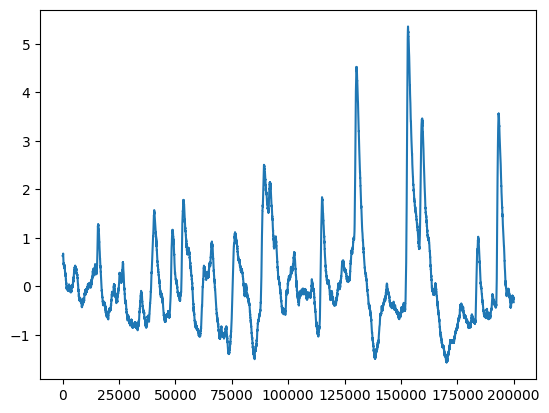

In [6]:
# Preprocess data
Fs = 10000  # Original sampling frequency in Hz
cutoff = 200  # Cutoff frequency in Hz
dopamine_filtered = butter_lowpass_filter(dopamine_raw.flatten(), cutoff, Fs)

# Moving z-score
window_size = Fs * 60  # 60 seconds
dopamine_zscore = moving_zscore(dopamine_filtered, window_size)

# Downsample (optional)
targetFs = 10000
downsample_factor = int(Fs/targetFs)
red_laser = red_laser_raw[::downsample_factor]
blue_laser = blue_laser_raw[::downsample_factor]
dopamine = dopamine_zscore[::downsample_factor]

print(f"Data shape: {dopamine.shape}")
print(f"Sampling rate: {targetFs} Hz")

# Plot sample data traces
plt.plot(dopamine[100*Fs:120*Fs])


## 1. Calculate PWM from Duty Cycle

The laser signals are binary (0/1). We calculate the duty cycle of each pulse and convert it to PWM values (0-255).


In [7]:
def extract_stim_pwm(
    clamp_trace,
    *,
    fs=10_000,
    duration=[2.0, 1.0, 6.0],                # e.g., [0.1, 0.5, 1.0] to snap
    inter_stim_min_s=3.0,
    low_pct=0.1,
    high_pct=99.99999999999999,
    pwm_resolution_bits=8,        # 8-bit → 0..255
    pwm=None                      # e.g., [20, 30, 40] to snap to known counts
):
    """
    Segment PWM stims by rising edges (> inter_stim_min_s gap), then compute duty from RAW analog.

    Returns:
        List[Tuple[int, int, float, int, float]]:
            (onset_sample, end_sample, duration_s, pwm_counts, duty_frac)

    Notes:
        - Sample indices are 0-based.
        - duty_frac is in [0, 1].
        - pwm_counts is snapped to `pwm` if provided.
        - If `duration` is provided, durations are snapped and end_sample is adjusted accordingly.
    """
    x = np.asarray(clamp_trace, dtype=float).ravel()
    n = x.size
    if n == 0:
        return []

    # Rising edges: threshold at half of max(x)
    rise = x > (x.max() / 2.0) if np.isfinite(x.max()) else np.zeros(n, dtype=bool)
    temp = np.diff(rise.astype(np.int8), prepend=0)
    idx = np.flatnonzero(temp == 1)
    if idx.size == 0:
        return []

    # Group edges into stim epochs using a minimum inter-stim gap
    gap_samp = int(round(inter_stim_min_s * fs))
    splits = np.where(np.diff(idx) > gap_samp)[0] + 1
    groups = np.split(idx, splits)

    # Percentile levels for duty computation
    V0 = np.percentile(x, low_pct)
    V1 = np.percentile(x, high_pct)
    if V1 <= V0:
        V0, V1 = float(np.nanmin(x)), float(np.nanmax(x))
        if not np.isfinite(V0) or not np.isfinite(V1) or V1 <= V0:
            # Degenerate trace; avoid division by zero
            V0, V1 = 0.0, 1.0

    max_count = (1 << int(pwm_resolution_bits)) - 1
    pwm_known = None if pwm is None or len(pwm) == 0 else np.asarray(pwm, dtype=int)

    out = []
    for g in groups:
        onset_idx = int(g[0])
        per_samp = int(round(np.median(np.diff(g)))) if g.size > 1 else 0
        end_idx = min(n - 1, int(g[-1]) + max(0, per_samp))

        seg = slice(onset_idx, end_idx + 1)  # inclusive end
        mu = float(x[seg].mean())

        duty_frac = float(np.clip((mu - V0) / (V1 - V0), 0.0, 1.0))
        pwm_counts = int(round(duty_frac * max_count))

        if pwm_known is not None:
            pwm_counts = int(pwm_known[np.argmin(np.abs(pwm_known - pwm_counts))])

        duration_s = (end_idx - onset_idx + 1) / float(fs)

        if duration is not None and len(duration) > 0:
            dset = np.asarray(duration, dtype=float)
            duration_s = float(dset[np.argmin(np.abs(dset - duration_s))])
            end_idx = min(n - 1, onset_idx + int(round(duration_s * fs)) - 1)

        out.append((onset_idx, end_idx, duration_s, pwm_counts, duty_frac))

    return out

In [8]:
# Calculate PWM for both channels using extract_stim_pwm
excite_pulses = extract_stim_pwm(red_laser, pwm=None)
inhibit_pulses = extract_stim_pwm(blue_laser, pwm=None)


## 2. Segment Different Stages of Experiment

Segment the data into:
- Baseline (no stimulation)
- Step sweeps (different PWM levels)
- Overlays (background + middle pulse)
- Manual (single pulses)


In [9]:
def segment_experiment(excite_pulses, inhibit_pulses, n_samples, Fs=10000):
    """
    Segment experiment into different stages based on timing.
    Uses output from extractPWMStim (includes duration_sec).
    
    Logic:
    1. Baseline: 5 min period with no stimulation
    2. Step sweeps: 3s pulses with 5s ITI (repeated pattern)
    3. Overlays: 9s continuous stimulation with varying patterns
    4. Manual: 2s single pulses

    Returns: 
    events: a df with the following columns:
        - start: start time
        - end: end time
        - pwm: pwm value
        - duration_sec: duration of the event
        - type: type of the event
    """

    events = pd.DataFrame(columns=['start', 'end', 'pwm', 'duration_sec', 'type'])

    # 0. Unpack df
    excite_pulses = excite_pulses
    inhibit_pulses = inhibit_pulses
    excite_onsets = [p[0] for p in excite_pulses]
    inhibit_onsets = [p[0] for p in inhibit_pulses]
    excite_offsets = [p[1] for p in excite_pulses]
    inhibit_offsets = [p[1] for p in inhibit_pulses]

    # Build a binary array indicating ON periods for each channel
    excite_on = np.zeros(n_samples, dtype=bool)
    inhibit_on = np.zeros(n_samples, dtype=bool)
    for start, end in zip(excite_onsets, excite_offsets):
        excite_on[start:end] = True
    for start, end in zip(inhibit_onsets, inhibit_offsets):
        inhibit_on[start:end] = True
    
    # 1. Find baseline (3 min with no stimulation)
    min_baseline_samples = int(3 * 60 * Fs)
    no_stim = ~(excite_on | inhibit_on)
    change = np.diff(no_stim.astype(int), prepend=0, append=0)
    starts = np.flatnonzero(change == 1)
    ends = np.flatnonzero(change == -1)
    for s, e in zip(starts, ends):
        if (e - s) >= min_baseline_samples:
            events.loc[len(events)] = (s, e, 0, (e - s) / Fs, 'baseline')
    
    
    # 2. Separate pulses by duration
    for pulse_info in excite_pulses:
        start, end, duration_sec, pwm, _ = pulse_info
        if 1.5 <= duration_sec <= 2.5:  # Step sweep (2 seconds)
            # Check if the pulse is actually overlay
            if inhibit_on[start:end].any():
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'excite_on_inhibit')
            else:
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'step_sweep_excite')
        elif 0.5 <= duration_sec <= 1.5:  # Manual (1 seconds)
            # Check if the pulse is actually overlay
            if inhibit_on[start:end].any():
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'excite_on_inhibit')
            else:
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'manual_excite')
        elif 5.5 <= duration_sec <= 6.5:  # Overlay background (6 seconds)
            events.loc[len(events)] = (start, end, pwm, duration_sec, 'inhibit_on_excite')
    
    for pulse_info in inhibit_pulses:
        start, end, duration_sec, pwm, _ = pulse_info
        if 1.5 <= duration_sec <= 2.5:  # Step sweep (2 seconds)
            # Check if the pulse is actually overlay
            if excite_on[start:end].any():
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'inhibit_on_excite')
            else:
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'step_sweep_inhibit')
        elif 0.5 <= duration_sec <= 1.5:  # Manual (1 seconds)
            if excite_on[start:end].any():
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'inhibit_on_excite')
            else:
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'manual_inhibit')
        elif 5.5 <= duration_sec <= 6.5:  # Overlay background (6 seconds)
            events.loc[len(events)] = (start, end, pwm, duration_sec, 'excite_on_inhibit')
    
    return events

events = segment_experiment(excite_pulses, inhibit_pulses, n_samples=len(dopamine))
events.head()


,start,end,pwm,duration_sec,type
0,0,2053121,0,205.3121,baseline
1,2053121,2073120,6,2.0000,step_sweep_excite
2,2123047,2143046,20,2.0000,step_sweep_excite
3,2192973,2212972,35,2.0000,step_sweep_excite
4,2262919,2282918,50,2.0000,step_sweep_excite


In [46]:
# How many unique durations are there?
events['duration_sec'].unique()



array([205.3121,   2.    ,   6.    ,   1.    ])

# Section 2: Baseline analysis


In [10]:
# # Combine dopamine from all baseline events together
# baseline_events = events[events['type'] == 'baseline']
# baseline_df = pd.concat([df.iloc[start:end] for start, end in zip(baseline_events['start'], baseline_events['end'])])

# # Calculate baseline stats and print them
# print(f"Baseline duration: {len(baseline_df) / Fs / 60:.2f} minutes")
# print(f"\nBaseline stats:")
# print(f"  Mean: {baseline_df['dopamine'].mean():.2f}")
# print(f"  Std: {baseline_df['dopamine'].std():.2f}")
# print(f"  Min: {baseline_df['dopamine'].min():.2f}")
# print(f"  Max: {baseline_df['dopamine'].max():.2f}")

# # Plot sample baseline dopamine and histogram
# fig, ax = plt.subplots(2, 1, figsize=(12, 8))
# ax[0].plot(baseline_df['time'] / 60, baseline_df['dopamine'], 'k-', alpha=0.7, linewidth=0.5)
# ax[0].set_xlabel('Time (minutes)', fontsize=12)
# ax[0].set_ylabel('Dopamine Signal', fontsize=12)
# ax[0].set_title('Baseline Dopamine Signal', fontsize=14)

# # Plot histogram of baseline dopamine
# ax[1].hist(baseline_df['dopamine'], bins=100, alpha=0.7, edgecolor='black')
# ax[1].axvline(baseline_df['dopamine'].mean(), color='red', linestyle='--', 
#             label=f"Mean: {baseline_df['dopamine'].mean():.2f}", linewidth=2)
# ax[1].axvline(baseline_df['dopamine'].mean() + baseline_df['dopamine'].std(), 
#             color='orange', linestyle='--', label='±1 Std', linewidth=1.5)
# ax[1].axvline(baseline_df['dopamine'].mean() - baseline_df['dopamine'].std(), 
#             color='orange', linestyle='--', linewidth=1.5)
# ax[1].set_xlabel('Dopamine Signal Value', fontsize=12)
# ax[1].set_ylabel('Frequency', fontsize=12)
# ax[1].set_title('Baseline Signal Distribution', fontsize=14)

# Section 3: Step sweep analysis

1. Group stim based on PWM level
2. Plot average dopamine response for each stim
3. Fit a FOPDT model for each stim 

In [25]:
from collections import defaultdict

# Group stimulations by PWM level for both channels
def group_stims_by_pwm(events, event_type):
    """Group stimulations by PWM level"""
    event_list = events[events['type'] == event_type]
    
    if len(event_list) == 0:
        return {}
    
    grouped = defaultdict(list)
    for _, event in event_list.iterrows():
        pwm_key = int(round(event['pwm']))
        if event['duration_sec'] < 5:
            grouped[pwm_key].append((event['start'], event['end'], event['duration_sec']))
    
    return dict(grouped)

# Group excitations
excite_step_sweep = group_stims_by_pwm(events, 'step_sweep_excite')
print(f"EXCITE stimulations:")
print(f"  Total: {sum(len(stims) for stims in excite_step_sweep.values())}")
for pwm_level in sorted(excite_step_sweep.keys()):
    print(f"  PWM {pwm_level}: {len(excite_step_sweep[pwm_level])} pulses")

# Group inhibitions  
inhibit_step_sweep = group_stims_by_pwm(events, 'step_sweep_inhibit')
print(f"\nINHIBIT stimulations:")
print(f"  Total: {sum(len(stims) for stims in inhibit_step_sweep.values())}")
for pwm_level in sorted(inhibit_step_sweep.keys()):
    print(f"  PWM {pwm_level}: {len(inhibit_step_sweep[pwm_level])} pulses")

# Overlay excitation
excite_overlay = group_stims_by_pwm(events, 'excite_on_inhibit')
print(f"\nEXCITE OVERLAY stimulations:")
print(f"  Total: {sum(len(stims) for stims in excite_overlay.values())}")
for pwm_level in sorted(excite_overlay.keys()):
    print(f"  PWM {pwm_level}: {len(excite_overlay[pwm_level])} pulses")
    
# Overlay inhibition
inhibit_overlay = group_stims_by_pwm(events, 'inhibit_on_excite')
print(f"\nINHIBIT OVERLAY stimulations:")
print(f"  Total: {sum(len(stims) for stims in inhibit_overlay.values())}")
for pwm_level in sorted(inhibit_overlay.keys()):
    print(f"  PWM {pwm_level}: {len(inhibit_overlay[pwm_level])} pulses")


EXCITE stimulations:
  Total: 50
  PWM 6: 10 pulses
  PWM 20: 10 pulses
  PWM 35: 10 pulses
  PWM 50: 10 pulses
  PWM 65: 10 pulses

INHIBIT stimulations:
  Total: 50
  PWM 24: 10 pulses
  PWM 46: 10 pulses
  PWM 68: 10 pulses
  PWM 90: 10 pulses
  PWM 112: 10 pulses

EXCITE OVERLAY stimulations:
  Total: 50
  PWM 5: 1 pulses
  PWM 6: 9 pulses
  PWM 20: 10 pulses
  PWM 35: 10 pulses
  PWM 50: 10 pulses
  PWM 65: 10 pulses

INHIBIT OVERLAY stimulations:
  Total: 50
  PWM 24: 10 pulses
  PWM 46: 10 pulses
  PWM 67: 10 pulses
  PWM 89: 2 pulses
  PWM 90: 8 pulses
  PWM 111: 10 pulses


## 3.2: Plot Average Dopamine Responses


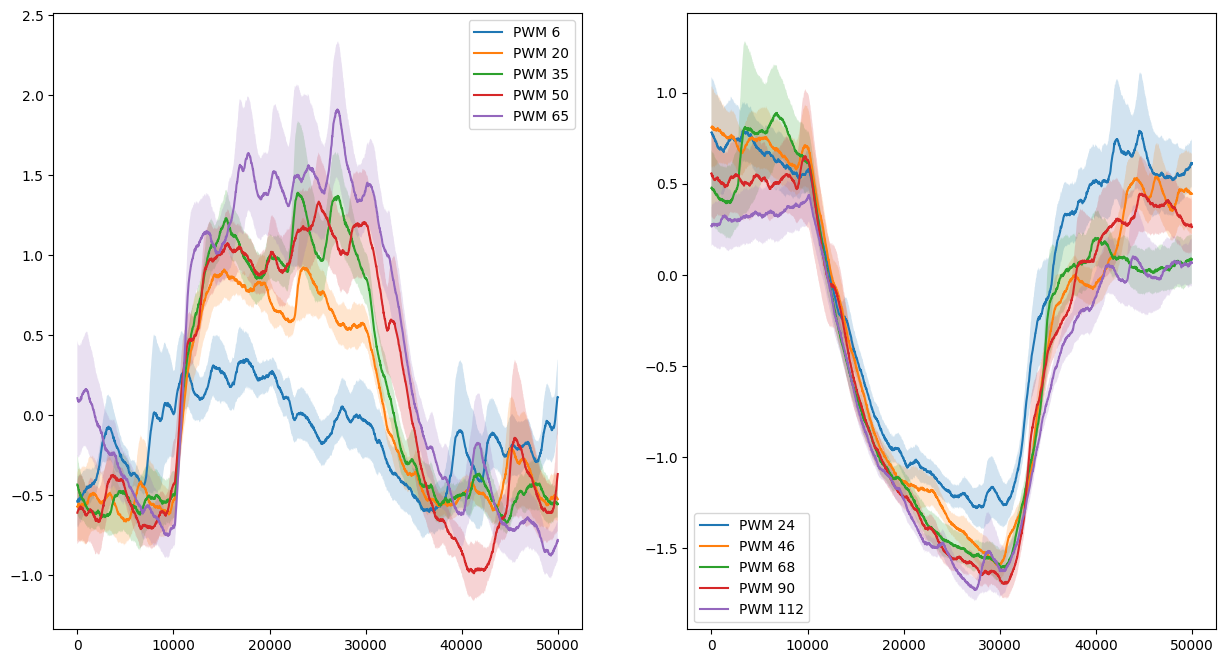

In [34]:
# Plot average dopamine responses for each PWM level
excite_grouped = excite_step_sweep
inhibit_grouped = inhibit_step_sweep

fig, axs = plt.subplots(1,2,figsize=(15,8))
for pwm in excite_grouped.keys():
    # Get stim onset time for all pulses
    stim_onset = [p[0] for p in excite_grouped[pwm]]
    stim_duration = excite_grouped[pwm][0][2] + 2
    aligned = get_traces(dopamine, stim_onset, pre_steps=int(1*targetFs), post_steps=int(stim_duration*targetFs))
    plot_sem(aligned, label=f'PWM {pwm}',ax=axs[0])
    axs[0].legend()

for pwm in inhibit_grouped.keys():
    # Get stim onset time for all pulses
    stim_onset = [p[0] for p in inhibit_grouped[pwm]]
    stim_duration = inhibit_grouped[pwm][0][2] + 2
    aligned = get_traces(dopamine, stim_onset, pre_steps=int(1*targetFs), post_steps=int(stim_duration*targetFs))
    plot_sem(aligned, label=f'PWM {pwm}',ax=axs[1])
    axs[1].legend()


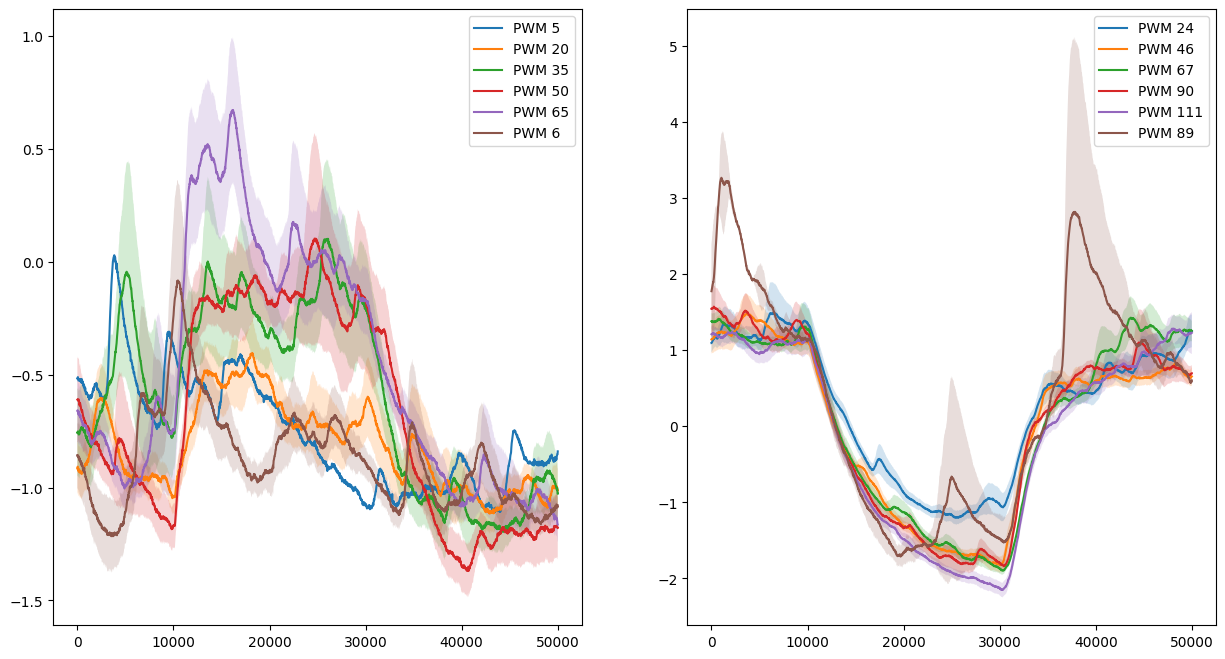

In [33]:
# Plot average dopamine responses for each PWM level
excite_grouped = excite_overlay
inhibit_grouped = inhibit_overlay

fig, axs = plt.subplots(1,2,figsize=(15,8))
for pwm in excite_grouped.keys():
    # Get stim onset time for all pulses
    stim_onset = [p[0] for p in excite_grouped[pwm]]
    stim_duration = excite_grouped[pwm][0][2] + 2
    aligned = get_traces(dopamine, stim_onset, pre_steps=int(1*targetFs), post_steps=int(stim_duration*targetFs))
    plot_sem(aligned, label=f'PWM {pwm}',ax=axs[0])
    axs[0].legend()

for pwm in inhibit_grouped.keys():
    # Get stim onset time for all pulses
    stim_onset = [p[0] for p in inhibit_grouped[pwm]]
    stim_duration = inhibit_grouped[pwm][0][2] + 2
    aligned = get_traces(dopamine, stim_onset, pre_steps=int(1*targetFs), post_steps=int(stim_duration*targetFs))
    plot_sem(aligned, label=f'PWM {pwm}',ax=axs[1])
    axs[1].legend()


## 3.3: Fit FOPDT Models


In [81]:
# Combine all the onset times of excite_step_sweep with pwm larger than 20 (keys)
excite_step_sweep_onsets = []
for pwm in excite_step_sweep.keys():
    if pwm >= 20:
        stim_onset = [p[0] for p in excite_grouped[pwm]]
        excite_step_sweep_onsets.append(stim_onset)

excite_step_sweep_onsets = np.concatenate(excite_step_sweep_onsets)

# Combine all the onset times of inhibit_step_sweep with pwm larger than 20 (keys)
inhibit_step_sweep_onsets = []
for pwm in inhibit_step_sweep.keys():
    if pwm >= 20:
        stim_onset = [p[0] for p in inhibit_grouped[pwm]]
        inhibit_step_sweep_onsets.append(stim_onset)

inhibit_step_sweep_onsets = np.concatenate(inhibit_step_sweep_onsets)

# Combine all the onset times of excite_overlay with pwm larger than 20 (keys)
excite_overlay_onsets = []
for pwm in excite_overlay.keys():
    if pwm >= 20:
        stim_onset = [p[0] for p in excite_overlay[pwm]]
        excite_overlay_onsets.append(stim_onset)

excite_overlay_onsets = np.concatenate(excite_overlay_onsets)

# Combine all the onset times of inhibit_overlay with pwm larger than 20 (keys)
inhibit_overlay_onsets = []
for pwm in inhibit_overlay.keys():
    if pwm >= 20:
        stim_onset = [p[0] for p in inhibit_overlay[pwm]]
        inhibit_overlay_onsets.append(stim_onset)

inhibit_overlay_onsets = np.concatenate(inhibit_overlay_onsets)

# Get aligned data across pwm levels
pre_time = 1 # seconds
post_time = 2 # seconds
stim_duration = 2 # seconds
dopamine_excite_step_sweep = get_traces(dopamine, excite_step_sweep_onsets, pre_steps=int(pre_time*targetFs), post_steps=int(post_time*targetFs))
dopamine_inhibit_step_sweep = get_traces(dopamine, inhibit_step_sweep_onsets, pre_steps=int(pre_time*targetFs), post_steps=int(post_time*targetFs))
dopamine_excite_overlay = get_traces(dopamine, excite_overlay_onsets, pre_steps=int(pre_time*targetFs), post_steps=int(post_time*targetFs))
dopamine_inhibit_overlay = get_traces(dopamine, inhibit_overlay_onsets, pre_steps=int(pre_time*targetFs), post_steps=int(post_time*targetFs))

In [80]:
import numpy as np
from scipy.optimize import least_squares

# ---- utilities reused -------------------------------------------------------
def _find_step_segment(u_on):
    """
    Locate the indices for the beginning and end of a step, and return the step amplitude.
    Parameters:
      u_on: array-like boolean or int (input ON/OFF over time)
    Returns:
      step_start_idx, step_end_idx, step_size
    """
    u = np.asarray(u_on, int)  # Convert to integer array
    change_indices = np.flatnonzero(np.diff(u) != 0)  # Indices of all state changes
    if change_indices.size == 0: 
        raise ValueError("No ON/OFF transition in u_on.")
    step_start_idx = change_indices[0]      # first transition: step starts
    # If there is a second change, step ends there, otherwise at end of u
    step_end_idx = (change_indices[1]+1) if change_indices.size > 1 else len(u)
    step_size = u[step_start_idx+1] - u[step_start_idx]  # +1 for ON, -1 for OFF
    return step_start_idx, step_end_idx, int(step_size)

def _fopdt_step(time, gain, tau, delay, baseline, step_size, step_start_time):
    """
    Standard First Order Plus Dead Time (FOPDT) step response.
    """
    time_effective = np.maximum(0.0, time - (step_start_time + delay))  # time after both step onset and delay
    return baseline + gain*step_size*(1.0 - np.exp(-time_effective/np.maximum(tau, 1e-9)))

def _sopdt_step(time, gain, wn, zeta, delay, baseline, step_size, step_start_time):
    """
    Standard Second Order Plus Dead Time (SOPDT) step response.
    """
    time_effective = np.maximum(0.0, time - (step_start_time + delay))
    wn = np.maximum(wn, 1e-9)    # natural frequency
    zeta = np.maximum(zeta, 1e-6) # damping ratio
    response = np.empty_like(time, float)
    # Underdamped case (oscillatory)
    if zeta < 1:
        wd = wn*np.sqrt(1 - zeta**2)  # damped natural frequency
        envelope = np.exp(-zeta*wn*time_effective)
        response[:] = baseline + gain*step_size*(1 - envelope*(np.cos(wd*time_effective) + (zeta/np.sqrt(1-zeta**2))*np.sin(wd*time_effective)))
    # Critically damped case
    elif np.isclose(zeta, 1.0, atol=1e-3):
        response[:] = baseline + gain*step_size*(1 - np.exp(-wn*time_effective)*(1 + wn*time_effective))
    # Overdamped case
    else:
        s1 = -wn*(zeta - np.sqrt(zeta**2 - 1))
        s2 = -wn*(zeta + np.sqrt(zeta**2 - 1))
        numerator = (s2*np.exp(s1*time_effective) - s1*np.exp(s2*time_effective))
        denominator = (s2 - s1)
        response[:] = baseline + gain*step_size*(1 - numerator/denominator)
    return response

def _metrics(y, yhat, param_count):
    """
    Compute model fit metrics: RMSE, R2, VAF, AIC, BIC.
    """
    y = np.asarray(y)
    yhat = np.asarray(yhat)
    n_points = y.size
    rss = np.sum((y - yhat)**2)  # residual sum of squares
    tss = np.sum((y - y.mean())**2) + 1e-12  # total sum of squares
    rmse = np.sqrt(rss/n_points)
    r2 = 1 - rss/tss
    vaf = 100*(1 - np.var(y - yhat)/np.var(y) if np.var(y)>0 else 0.0)  # Variance Accounted For (%)
    sigma2 = rss/n_points  # variance of residuals
    aic = 2*param_count + n_points*np.log(sigma2 + 1e-12)     # Akaike Information Criterion
    bic = param_count*np.log(n_points) + n_points*np.log(sigma2 + 1e-12)  # Bayesian Information Criterion
    return dict(RMSE=rmse, R2=r2, VAF=vaf, AIC=aic, BIC=bic)

# ---- GLOBAL FOPDT: shared gain, tau, delay; individual baseline per trial ----
def fit_fopdt(y, u_on, Fs=10000, pre_s=1.0):
    """
    Fit a First-Order Plus Dead Time model with shared K/tau/L, and per-trial baseline.
    Args:
        y: shape (n_trials, n_samples) or (n_samples,)
        u_on: input ON array
        Fs: sampling rate [Hz]
        pre_s: window (s) for baseline estimation prior to step
    Returns:
        Fit and metrics dictionary.
    """
    dt = 1.0 / Fs
    Y = np.asarray(y, float)
    if Y.ndim == 1: 
        Y = Y[None, :]  # Ensure 2D array
    n_trials, n_samples = Y.shape
    time_axis = np.arange(n_samples)*dt  # x axis (seconds)
    step_start_idx, step_end_idx, step_size = _find_step_segment(u_on)
    step_start_time = (step_start_idx+1)*dt
    baseline_window = max(1, int(round(pre_s/dt)))
    # Estimate per-trial baseline y0s as median before step
    y0_trials = np.array([np.median(Y[i, max(0,step_start_idx-baseline_window):step_start_idx]) 
                          for i in range(n_trials)], float)
    # Heuristic initials using trial-averaged data
    y_mean = Y.mean(axis=0)
    y0_mean = float(np.median(y_mean[max(0,step_start_idx-baseline_window):step_start_idx]))
    y_end_mean = float(np.median(y_mean[max(step_start_idx+1, step_end_idx-baseline_window):step_end_idx]))
    delta_y = (y_end_mean - y0_mean)
    gain_init = delta_y/max(step_size,1e-9)
    # Use 63% rule (1 - exp(-1)) for initial tau, tangent for L (simple heuristics)
    target_level = y0_mean + 0.632*delta_y
    after_step = np.arange(n_samples) >= (step_start_idx+1)
    crossing_point = np.flatnonzero(after_step & ((y_mean - target_level)*(np.sign(delta_y) if delta_y!=0 else 1) >= 0))
    tau_init = ((crossing_point[0]-(step_start_idx+1))*dt) if crossing_point.size else 0.25*((step_end_idx-1)-(step_start_idx+1))*dt
    delay_init = 0.0

    # parameter vector: [gain, tau, delay, y0_trial_1, ..., y0_trial_n]
    x0 = np.r_[gain_init, max(tau_init, dt), max(delay_init, 0.0), y0_trials]
    lb = np.r_[-1e6, 1e-6, 0.0, y0_trials - 5*abs(delta_y+1e-6)]  # lower bounds
    ub = np.r_[ 1e6, 1e6, (time_axis[step_end_idx-1]-step_start_time), y0_trials + 5*abs(delta_y+1e-6)]  # upper

    def resid(param_vec):
        gain, tau, delay = param_vec[0], param_vec[1], param_vec[2]
        baseline_trials = param_vec[3:]
        resids = []
        for trial_idx in range(n_trials):
            yhat = _fopdt_step(time_axis, gain, tau, delay, baseline_trials[trial_idx], step_size, step_start_time)
            # Only fit response region after step.
            resids.append(Y[trial_idx, step_start_idx+1:step_end_idx] - yhat[step_start_idx+1:step_end_idx])
        return np.concatenate(resids)

    # Fit using least squares
    sol = least_squares(resid, x0, bounds=(lb, ub), max_nfev=40000)
    gain, tau, delay = sol.x[0], sol.x[1], sol.x[2]
    baseline_trials_fitted = sol.x[3:]
    # predictions (mean-of-preds for plotting)
    yhat_trials = np.vstack([_fopdt_step(time_axis, gain, tau, delay, baseline_trials_fitted[i], step_size, step_start_time) 
                             for i in range(n_trials)])
    yhat_mean = yhat_trials.mean(axis=0)
    return {"params": {"K":gain,"tau":tau,"L":delay,"y0_per_trial":baseline_trials_fitted,"du":step_size,"t0":step_start_time},
            "yhat_mean": yhat_mean, "yhat_trials": yhat_trials,
            "metrics": _metrics(y, yhat_mean, param_count=3+len(baseline_trials_fitted))}

# ---- GLOBAL SOPDT: shared K,wn,zeta,delay; per-trial baseline ---------------
def fit_sopdt(y, u_on, Fs=10000, pre_s=1.0):
    """
    Fit a Second-Order Plus Dead Time model with shared K, wn, zeta, L and per-trial baseline.
    Args:
        y: shape (n_trials, n_samples) or (n_samples,)
        u_on: input ON array
        Fs: sampling rate [Hz]
        pre_s: window (s) for baseline estimation prior to step
    Returns:
        Fit and metrics dictionary.
    """
    dt = 1.0 / Fs
    Y = np.asarray(y, float)
    if Y.ndim == 1: 
        Y = Y[None, :]
    n_trials, n_samples = Y.shape
    time_axis = np.arange(n_samples)*dt
    step_start_idx, step_end_idx, step_size = _find_step_segment(u_on)
    step_start_time = (step_start_idx+1)*dt
    baseline_window = max(1, int(round(pre_s/dt)))
    y0_trials = np.array([np.median(Y[i, max(0,step_start_idx-baseline_window):step_start_idx]) 
                          for i in range(n_trials)], float)
    y_mean = Y.mean(axis=0)
    y0_mean = float(np.median(y_mean[max(0,step_start_idx-baseline_window):step_start_idx]))
    y_end_mean = float(np.median(y_mean[max(step_start_idx+1,step_end_idx-baseline_window):step_end_idx]))
    delta_y = (y_end_mean - y0_mean)
    gain_init = delta_y/max(step_size,1e-9)
    env_tau_init = max(dt, 0.25*((step_end_idx-1)-(step_start_idx+1))*dt)
    zeta_init = 0.7
    wn_init = 1.0/max(zeta_init*env_tau_init, dt)  # initial natural frequency
    delay_init = 0.0

    # parameter vector: [K, wn, zeta, delay, y0_1, ...]
    x0 = np.r_[gain_init, wn_init, zeta_init, delay_init, y0_trials]
    lb = np.r_[-1e6, 1e-6, 1e-3, 0.0, y0_trials - 5*abs(delta_y+1e-6)]
    ub = np.r_[ 1e6, 1e3,  10.0, (time_axis[step_end_idx-1]-step_start_time), y0_trials + 5*abs(delta_y+1e-6)]

    def resid(param_vec):
        gain, wn, zeta, delay = param_vec[0], param_vec[1], param_vec[2], param_vec[3]
        baseline_trials = param_vec[4:]
        resids = []
        for trial_idx in range(n_trials):
            yhat = _sopdt_step(time_axis, gain, wn, zeta, delay, baseline_trials[trial_idx], step_size, step_start_time)
            resids.append(Y[trial_idx, step_start_idx+1:step_end_idx] - yhat[step_start_idx+1:step_end_idx])
        return np.concatenate(resids)

    sol = least_squares(resid, x0, bounds=(lb, ub), max_nfev=60000)
    gain, wn, zeta, delay = sol.x[0], sol.x[1], sol.x[2], sol.x[3]
    baseline_trials_fitted = sol.x[4:]
    yhat_trials = np.vstack([
        _sopdt_step(time_axis, gain, wn, zeta, delay, baseline_trials_fitted[i], step_size, step_start_time) 
        for i in range(n_trials)])
    yhat_mean = yhat_trials.mean(axis=0)
    return {"params": {"K":gain,"wn":wn,"zeta":zeta,"L":delay,"y0_per_trial":baseline_trials_fitted,"du":step_size,"t0":step_start_time},
            "yhat_mean": yhat_mean, "yhat_trials": yhat_trials,
            "metrics": _metrics(y, yhat_mean, param_count=4+len(baseline_trials_fitted))}


In [117]:
def fit_and_plot_compare(y, u_on, Fs=10000):
    dt = 1.0 / Fs
    y = np.asarray(y, float); t = np.arange(y.shape[1])*dt
    f1 = fit_fopdt(y, u_on, Fs=Fs)
    f2 = fit_sopdt(y, u_on, Fs=Fs)

    # Plot fitted trace and bar plots of all metrics, each in a separate subplot
    metrics = [f1["metrics"], f2["metrics"]]
    labels = ["FOPDT", "SOPDT"]
    metric_keys = ["R2", "RMSE", "VAF", "AIC", "BIC"]
    metric_pretty_names = {
        "R2": "R²",
        "RMSE": "RMSE",
        "VAF": "VAF",
        "AIC": "AIC",
        "BIC": "BIC"
    }
    n_metrics = len(metric_keys)
    fig, axes = plt.subplots(1, 1+n_metrics, figsize=(3*(1+n_metrics),5), constrained_layout=True)

    # First subplot: fit traces
    plot_sem(y, t, label="data", ax=axes[0])
    axes[0].plot(t, f1["yhat_mean"], lw=1.6, label="FOPDT fit")
    axes[0].plot(t, f2["yhat_mean"], lw=1.6, label="SOPDT fit")
    axes[0].set_xlabel("time (s)"); 
    axes[0].set_ylabel("output"); 
    axes[0].set_title("Model fit comparison"); 
    axes[0].legend()

    # Next subplots: each metric bar plot
    for i, mkey in enumerate(metric_keys):
        axes[i+1].bar(labels, [m[mkey] for m in metrics])
        axes[i+1].set_xlabel("model")
        axes[i+1].set_ylabel(metric_pretty_names.get(mkey, mkey))
        axes[i+1].set_title(f"{metric_pretty_names.get(mkey, mkey)}")
    
    plt.show()

    return f1, f2


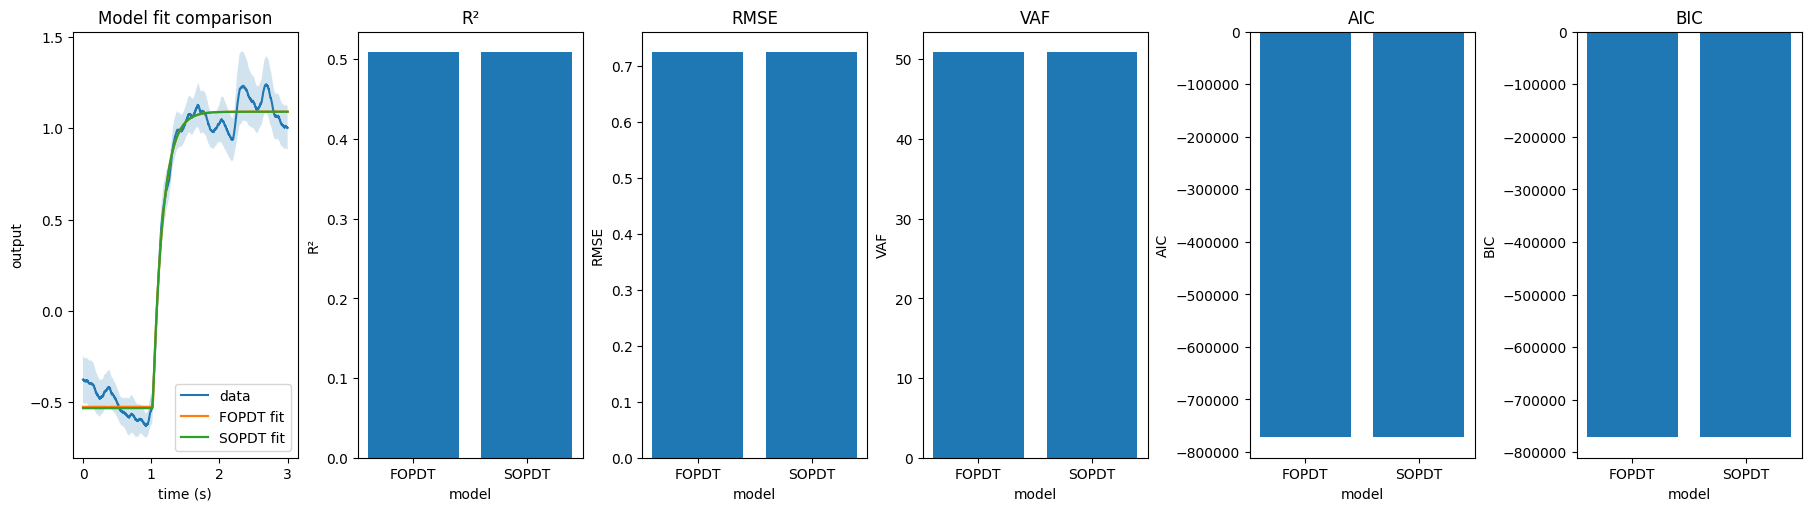

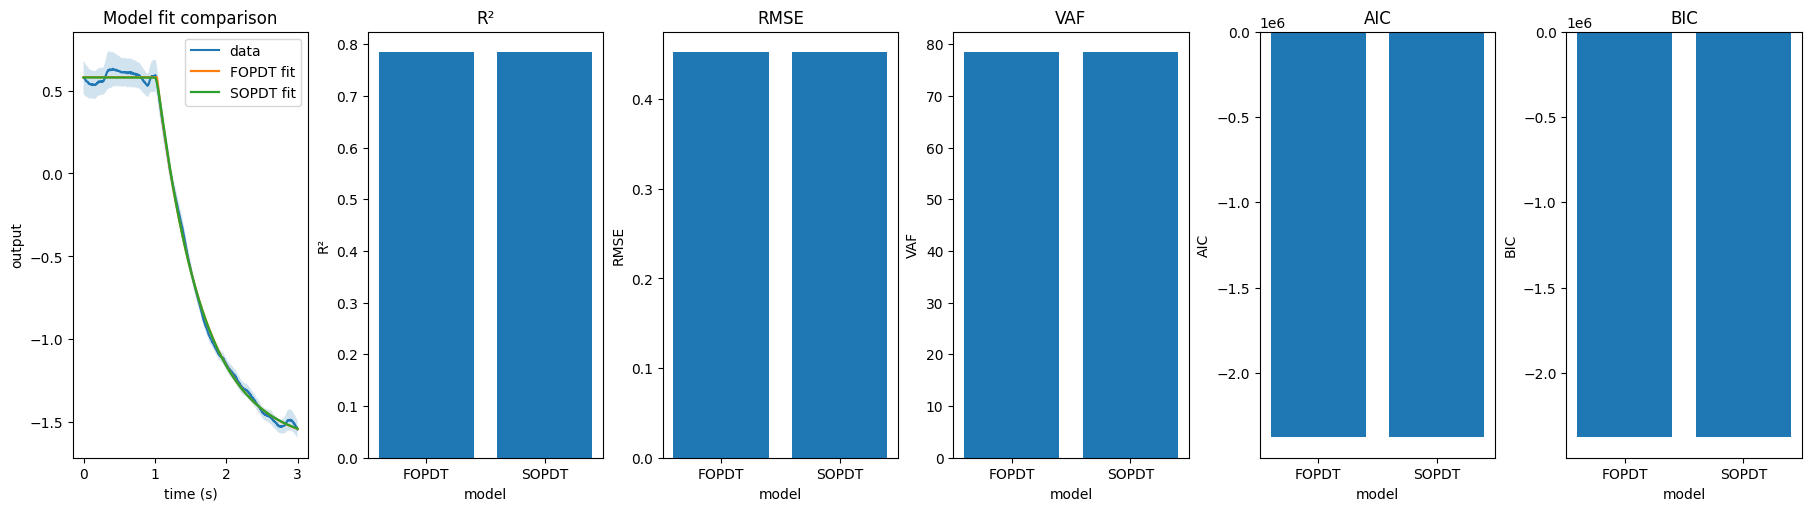

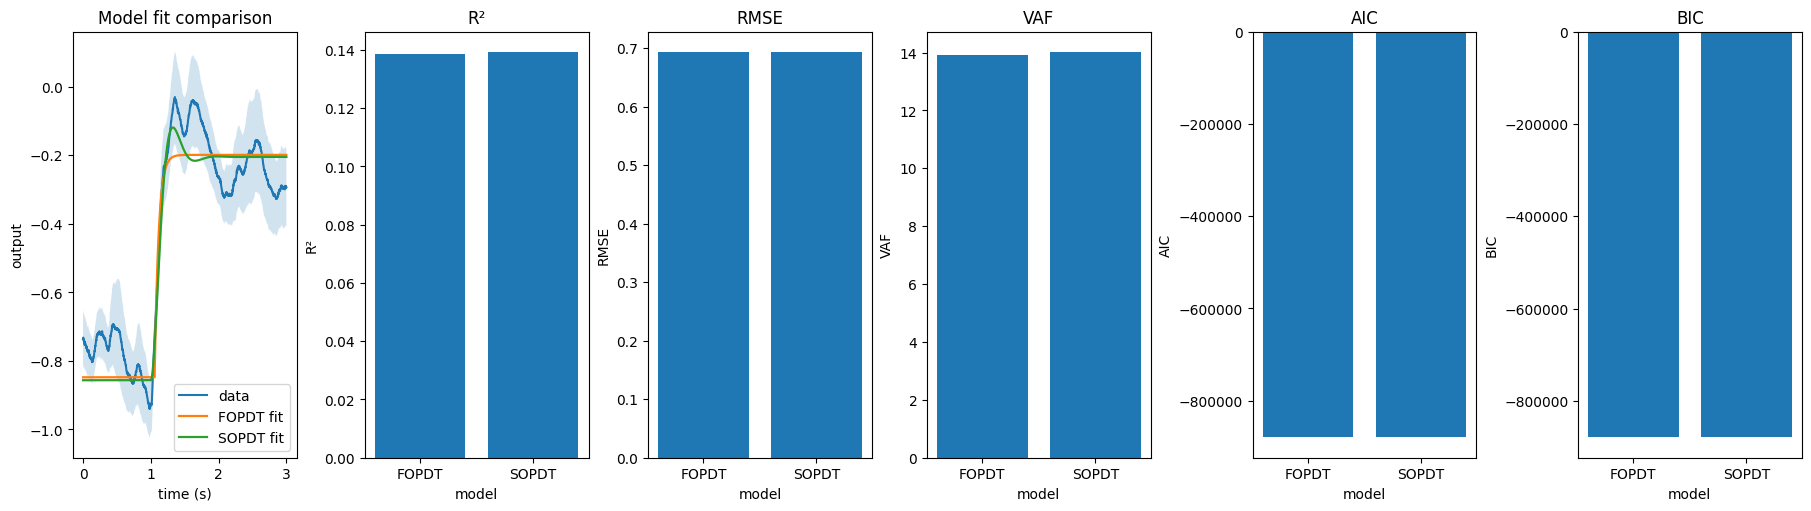

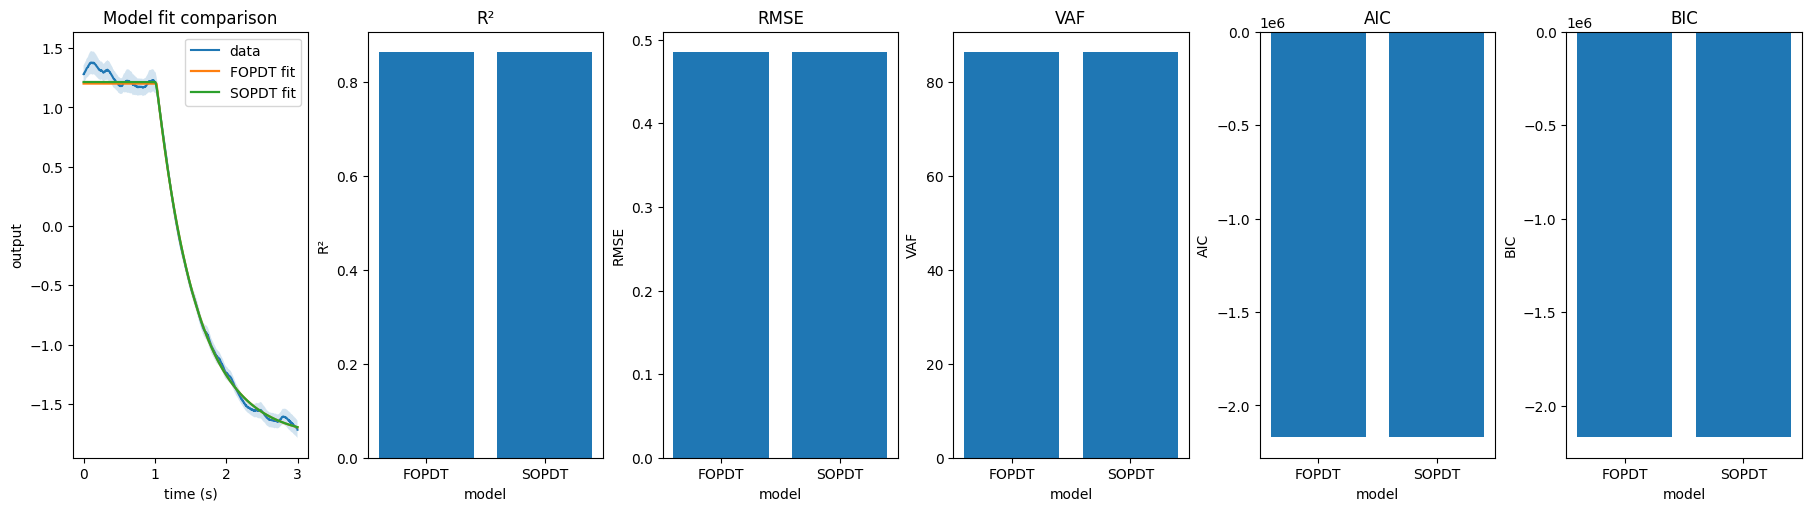

FOPDT params for excite step sweep:
K: 1.6160229585376176, tau: 0.14444683805738773, L: 0.023044480776781895
K: -2.2218616813167267, tau: 0.6374964604035898, L: 0.027677804882084486
K: 0.6488312891145247, tau: 0.05737565030342054, L: 0.05587909590220328
K: -2.9901162790681526, tau: 0.5652593681447925, L: 0.022892182623614605


In [87]:
# R2: lower is better
# RMSE: lower is better
# VAF: higher is better
# AIC: lower is better
# BIC: lower is better
u_on_excite = np.zeros(dopamine_excite_step_sweep.shape[1])
u_on_excite[pre_time*targetFs:pre_time*targetFs+stim_duration*targetFs] = 1
u_on_inhibit = np.zeros(dopamine_inhibit_step_sweep.shape[1])
u_on_inhibit[pre_time*targetFs:pre_time*targetFs+stim_duration*targetFs] = 1

# Fit FOPDT and SOPDT models
f1_excite_step_sweep, f2_excite_step_sweep = fit_and_plot_compare(dopamine_excite_step_sweep, u_on_excite)
f1_inhibit_step_sweep, f2_inhibit_step_sweep = fit_and_plot_compare(dopamine_inhibit_step_sweep, u_on_inhibit)
f1_excite_overlay, f2_excite_overlay = fit_and_plot_compare(dopamine_excite_overlay, u_on_excite)
f1_inhibit_overlay, f2_inhibit_overlay = fit_and_plot_compare(dopamine_inhibit_overlay, u_on_inhibit)

# Print K, tau, L for FOPDT models across all conditions
# K: gain, tau: time constant, L: delay (dead time)
print("FOPDT params for excite step sweep:")
print(f"K: {f1_excite_step_sweep['params']['K']}, tau: {f1_excite_step_sweep['params']['tau']}, L: {f1_excite_step_sweep['params']['L']}")
print(f"K: {f1_inhibit_step_sweep['params']['K']}, tau: {f1_inhibit_step_sweep['params']['tau']}, L: {f1_inhibit_step_sweep['params']['L']}")
print(f"K: {f1_excite_overlay['params']['K']}, tau: {f1_excite_overlay['params']['tau']}, L: {f1_excite_overlay['params']['L']}")
print(f"K: {f1_inhibit_overlay['params']['K']}, tau: {f1_inhibit_overlay['params']['tau']}, L: {f1_inhibit_overlay['params']['L']}")


In [125]:
import math
from typing import Dict, Optional

def _sopdt_tau12_from_wn_zeta(wn: float, zeta: float):
    """
    Given wn (natural frequency) and zeta (damping ratio),
    calculate tau1 and tau2 for a SOPDT model.

    Solves:
        tau1 + tau2 = 2*zeta/wn
        tau1 * tau2 = 1/wn**2
    """
    S = 2.0 * zeta / wn
    P = 1.0 / (wn ** 2)
    discriminant = max(S ** 2 - 4.0 * P, 0.0)
    t1 = 0.5 * (S + math.sqrt(discriminant))
    t2 = 0.5 * (S - math.sqrt(discriminant))

    # Enforce tau1 >= tau2 > 0
    tau1, tau2 = max(t1, t2), min(t1, t2)
    if tau2 <= 0:
        # If numerical issue, fall back to equal times
        tau1 = tau2 = S / 2.0
    return tau1, tau2

def _series_to_ideal(Kc: float, Ti: float, Td: float):
    """
    Map series PID form to ideal (parallel) PID form as per Skogestad (Eq 5.30).

    Args:
        Kc: Proportional gain (series form)
        Ti: Integral time (series form)
        Td: Derivative time (series form)

    Returns:
        Tuple (Kp, Ti, Td) in parallel (ideal) form.
    """
    if Td <= 0 or Ti <= 0:
        return Kc, Ti, 0.0
    factor = 1.0 + Td / Ti
    return Kc * factor, Ti * factor, Td / factor

def tune_pid(
    params: Dict[str, float],
    method: str = "SIMC",                # PID tuning method: "SIMC" or "ZN_open"
    form: str = "parallel",              # Controller form; "parallel" gives Kp, Ki, Kd
    tau_c: Optional[float] = None,       # Desired closed-loop time constant; defaults to theta
    improved_pi: bool = True,            # SIMC improvement: tau1 -> tau1 + theta/3 for PI
    derivative_filter_N: float = 10.0    # Derivative filter parameter N
) -> Dict[str, float]:
    k = float(params["K"])
    theta = float(params.get("L", 0.0))

    # Get model time constants
    tau1 = params.get("tau", None) or params.get("tau1", None)
    tau2 = params.get("tau2", None)

    # If given wn and zeta, convert to tau1/tau2
    if "wn" in params and "zeta" in params:
        tau1, tau2 = _sopdt_tau12_from_wn_zeta(float(params["wn"]), float(params["zeta"]))

    tauc = float(tau_c) if tau_c is not None else float(theta)

    if method.upper() == "SIMC":
        # SIMC: FOPDT yields a PI controller; SOPDT yields a PID
        if tau2 is None:
            # FOPDT: PI controller
            t1_eff = float(tau1)
            if improved_pi:
                t1_eff = float(tau1) + theta / 3.0

            Kc_series = (t1_eff / (tauc + theta)) / k
            Ti_series = min(t1_eff, 4.0 * (tauc + theta))
            Td_series = 0.0
        else:
            # SOPDT: PID controller (series form)
            Kc_series = (tau1 / (tauc + theta)) / k
            Ti_series = min(tau1, 4.0 * (tauc + theta))
            Td_series = float(tau2)

        # Convert to ideal (parallel) form
        Kp_ideal, Ti_ideal, Td_ideal = _series_to_ideal(Kc_series, Ti_series, Td_series)
        Kp = Kp_ideal
        Ki = (Kp / Ti_ideal) if Ti_ideal > 0 else 0.0
        Kd = Kp * Td_ideal

        return {
            "method": "SIMC",
            "Kp": Kp,
            "Ki": Ki,
            "Kd": Kd,
            "Ti": Ti_ideal,
            "Td": Td_ideal,
            "tau_c": tauc,
            "N": derivative_filter_N
        }

    elif method.upper() == "ZN_OPEN":
        # Ziegler–Nichols reaction curve method for FOPDT
        if tau1 is None or theta <= 0:
            raise ValueError(
                "ZN_open requires FOPDT with tau (tau1) and positive dead time L=theta."
            )
        Kp = 1.2 * (tau1 / (k * theta))
        Ti = 2.0 * theta
        Td = 0.5 * theta
        Ki = Kp / Ti
        Kd = Kp * Td
        return {
            "method": "ZN_open",
            "Kp": Kp,
            "Ki": Ki,
            "Kd": Kd,
            "Ti": Ti,
            "Td": Td,
            "N": derivative_filter_N
        }

    elif method.upper() == "CHR":
        # Chien–Hrones–Reswick method (CHR) for FOPDT (setpoint, 0% overshoot)
        # Reference: https://en.wikipedia.org/wiki/PID_controller#Chien,_Hrones,_and_Reswick_tuning_method
        # Only FOPDT supported here
        if tau1 is None or theta <= 0:
            raise ValueError(
                "CHR method requires FOPDT with tau (tau1) and positive dead time L=theta."
            )
        # CHR constants for setpoint, 0% overshoot (PI, PID)
        if tau_c is None:
            tau_c = tau1  # Default: tau_c = process time constant

        # You may want to extend with options for "regulator/servo", "0%/20% overshoot"
        # Below: setpoint, 0% overshoot (PID)
        Kp = 0.6 * (tau1 / (k * theta))
        Ti = tau1
        Td = 0.5 * theta
        Ki = Kp / Ti
        Kd = Kp * Td
        return {
            "method": "CHR",
            "Kp": Kp,
            "Ki": Ki,
            "Kd": Kd,
            "Ti": Ti,
            "Td": Td,
            "N": derivative_filter_N
        }
            
    else:
        raise ValueError("Unknown method. Use 'SIMC' or 'ZN_open'.")


In [128]:
# FOPDT for excite
K = f1_excite_step_sweep['params']['K']
tau = f1_excite_step_sweep['params']['tau']
L = f1_excite_step_sweep['params']['L']
params_fopdt = {"K": K, "tau": tau, "L": L}
gains_pi = tune_pid(params_fopdt, method="SIMC", tau_c=L)  # returns PI (Kd=0)

# SOPDT for excite
K = f2_excite_step_sweep['params']['K']
wn = f2_excite_step_sweep['params']['wn']
zeta = f2_excite_step_sweep['params']['zeta']
L = f2_excite_step_sweep['params']['L']
params_sopdt = {"K": K, "wn": wn, "zeta": zeta, "L": L}
gains_pid = tune_pid(params_sopdt, method="SIMC")  # returns full PID

# Ziegler–Nichols open-loop (FOPDT only)
gains_zn = tune_pid(params_fopdt, method="ZN_open")

# Chien–Hrones–Reswick (CHR)
gains_chr = tune_pid(params_fopdt, method="CHR")

# Print PID gains (two decimal places)
print(f"PI gains for excite: { {k: (v if isinstance(v, str) else f'{v:.2f}') for k,v in gains_pi.items()} }")
print(f"PID gains for excite: { {k: (v if isinstance(v, str) else f'{v:.2f}') for k,v in gains_pid.items()} }")
print(f"ZN gains for excite: { {k: (v if isinstance(v, str) else f'{v:.2f}') for k,v in gains_zn.items()} }")
print(f"CHR gains for excite: { {k: (v if isinstance(v, str) else f'{v:.2f}') for k,v in gains_chr.items()} }")

PI gains for excite: {'method': 'SIMC', 'Kp': '2.04', 'Ki': '13.43', 'Kd': '0.00', 'Ti': '0.15', 'Td': '0.00', 'tau_c': '0.02', 'N': '10.00'}
PID gains for excite: {'method': 'SIMC', 'Kp': '3.53', 'Ki': '29.90', 'Kd': '0.03', 'Ti': '0.12', 'Td': '0.01', 'tau_c': '0.01', 'N': '10.00'}
ZN gains for excite: {'method': 'ZN_open', 'Kp': '4.65', 'Ki': '100.99', 'Kd': '0.05', 'Ti': '0.05', 'Td': '0.01', 'N': '10.00'}
CHR gains for excite: {'method': 'CHR', 'Kp': '2.33', 'Ki': '16.11', 'Kd': '0.03', 'Ti': '0.14', 'Td': '0.01', 'N': '10.00'}


In [129]:
# FOPDT for inhibit
K = f1_inhibit_step_sweep['params']['K']
tau = f1_inhibit_step_sweep['params']['tau']
L = f1_inhibit_step_sweep['params']['L']
params_fopdt = {"K": K, "tau": tau, "L": L}
gains_pi = tune_pid(params_fopdt, method="SIMC", tau_c=L)  # returns PI (Kd=0)

# SOPDT for inhibit
K = f2_inhibit_step_sweep['params']['K']
wn = f2_inhibit_step_sweep['params']['wn']
zeta = f2_inhibit_step_sweep['params']['zeta']
L = f2_inhibit_step_sweep['params']['L']
params_sopdt = {"K": K, "wn": wn, "zeta": zeta, "L": L}
gains_pid = tune_pid(params_sopdt, method="SIMC", tau_c=0.1)  # returns full PID

# Ziegler–Nichols open-loop (FOPDT only)
gains_zn = tune_pid(params_fopdt, method="ZN_open")

# Chien–Hrones–Reswick (CHR)
gains_chr = tune_pid(params_fopdt, method="CHR")

# Print PID gains (two decimal places)
print(f"PI gains for inhibit: { {k: (v if isinstance(v, str) else f'{v:.2f}') for k,v in gains_pi.items()} }")
print(f"PID gains for inhibit: { {k: (v if isinstance(v, str) else f'{v:.2f}') for k,v in gains_pid.items()} }")
print(f"ZN gains for inhibit: { {k: (v if isinstance(v, str) else f'{v:.2f}') for k,v in gains_zn.items()} }")
print(f"CHR gains for inhibit: { {k: (v if isinstance(v, str) else f'{v:.2f}') for k,v in gains_chr.items()} }")

PI gains for inhibit: {'method': 'SIMC', 'Kp': '-5.26', 'Ki': '-23.75', 'Kd': '-0.00', 'Ti': '0.22', 'Td': '0.00', 'tau_c': '0.03', 'N': '10.00'}
PID gains for inhibit: {'method': 'SIMC', 'Kp': '-3.07', 'Ki': '-7.11', 'Kd': '-0.09', 'Ti': '0.43', 'Td': '0.03', 'tau_c': '0.10', 'N': '10.00'}
ZN gains for inhibit: {'method': 'ZN_open', 'Kp': '-12.44', 'Ki': '-224.72', 'Kd': '-0.17', 'Ti': '0.06', 'Td': '0.01', 'N': '10.00'}
CHR gains for inhibit: {'method': 'CHR', 'Kp': '-6.22', 'Ki': '-9.76', 'Kd': '-0.09', 'Ti': '0.64', 'Td': '0.01', 'N': '10.00'}


# Section 4: Overlay analysis

# Section 5: Manual overlay analysis
